# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.14484091  1.15899641 -0.2171274  -1.99853303] 0 1.0 True {}
state, action, reward, done, info
[-0.10593986 -0.93815841  0.21964675  1.73781463] 0 1.0 True {}
state, action, reward, done, info
[ 0.10584616  0.97726318 -0.21944104 -1.78747062] 1 1.0 True {}
state, action, reward, done, info
[ 0.11808262  1.34625522 -0.21847809 -2.29440815] 1 1.0 True {}
state, action, reward, done, info
[-0.21424401 -1.00566039  0.22603744  1.6844058 ] 1 1.0 True {}
state, action, reward, done, info
[ 0.21348068  0.78964734 -0.22638012 -1.34958902] 0 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
    actions_ = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs_ = tf.placeholder(tf.float32, [None], name='target')
    return inputs_, actions_, targetQs_    

In [6]:
def generator(x, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.1 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(nl1, hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.1 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [7]:
def model_loss(inputs_, hidden_size, actions_, action_size, targetQs_):
    # Output layer
    output = generator(x=inputs_, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions_, action_size)

    ### Train with loss (targetQ - Q)^2
    # output has length 2, for two actions. This next line chooses
    # one value from output (per row) according to the one-hot encoded actions.
    Q = tf.reduce_sum(tf.multiply(output, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs_ - Q))
    
    return output, Q, loss

In [8]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.inputs_, self.actions_, self.targetQs_ = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.output, self.Q, self.loss = model_loss(action_size=action_size, actions_=self.actions_, 
                                                    hidden_size=hidden_size, 
                                                    inputs_=self.inputs_, targetQs_=self.targetQs_)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

In [9]:
# class QNetwork:
#     def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
#         # state inputs to the Q-network
#         with tf.variable_scope(name):
#             # Given data
#             self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
#             self.actions_ = tf.placeholder(tf.int32, [None], name='actions')

#             # One hot encode the actions to later choose the Q-value for the action
#             one_hot_actions = tf.one_hot(self.actions_, action_size)

#             # ReLU hidden layers
#             fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
#             fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

#             # Linear output layer
#             self.output = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None)
                    
#             ### Train with loss (targetQ - Q)^2
#             # output has length 2, for two actions. This next line chooses
#             # one value from output (per row) according to the one-hot encoded actions.
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)

#             # Target Q values for training
#             self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

#             # error backpropagation: loss and opt
#             self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
#             self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [10]:
# tf.layers.dense(
#     inputs, --- GOOD
#     units, ----- GOOD
#     activation=None,
#     use_bias=True,  ----------- GOOD
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ----------GOOD
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ----------------- ???
#     name=None,
#     reuse=None
# )

In [11]:
# def generator(in_state, state_size=4, action_size=2, hidden_size=10, alpha=0.1, reuse=False, training=True):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=in_state, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(nl1, hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits_state_next = tf.layers.dense(nl2, state_size, trainable=False)        
#         logits_action = tf.layers.dense(nl2, action_size, trainable=False)        
#         # out = tf.tanh(logits)

#         return logits_state_next, logits_action

In [12]:
# def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, reuse=False, alpha=0.1):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # First fully connected layer
#         fused = tf.concat(values=[in_state_next, out_action], axis=1)
#         h1 = tf.layers.dense(fused, hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=True)
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(nl1, hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=True)
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(nl2, 1, trainable=False)   
#         out = tf.sigmoid(logits)

#         # logits for loss and reward/prob/out
#         return out, logits

In [13]:
# def model_inputs(state_size=4):
#     # Current input states
#     inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin
#     # print(self.inputs_)

#     # Current output action: for generation/prediction
#     actions_ = tf.placeholder(tf.int32, [None], name='actions')
#     # print(actions_)

#     # Next input real and generated/fake/predicted
#     inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
#     # print(self.inputs_next)
    
#     return inputs_, actions_, inputs_next

In [14]:
# def model_loss(inputs_, actions_, inputs_next, action_size=2, hidden_size=10, alpha=0.1):
#     """
#     Get the loss for the discriminator and generator
#     :param inputs_: real input states given
#     :param actions_: real actions given
#     :param inputs_next: real next input states given
#     :return: A tuple of (discriminator loss, generator loss)
#     """
#     input_state_gen, out_action_gen = generator(in_state=inputs_, hidden_size=hidden_size)
#     _, d_logits_fake = discriminator(in_state_next=input_state_gen, out_action=out_action_gen, hidden_size=hidden_size)
#     actions_onehot = tf.one_hot(actions_, action_size)
#     _, d_logits_real = discriminator(in_state_next=inputs_next, out_action=actions_onehot, hidden_size=hidden_size, reuse=True)

#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
#     d_loss = d_loss_real + d_loss_fake
    
#     g_loss = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
#     return d_loss, g_loss

In [15]:
# def model_opt(d_loss, g_loss, learning_rate):
#     """
#     Get optimization operations
#     :param d_loss: Discriminator loss Tensor for reward function
#     :param g_loss: Generator loss Tensor for action & next state predicton
#     :param learning_rate: Learning Rate Placeholder
#     :return: A tuple of (discriminator training operation, generator training operation)
#     """
#     # Get weights and bias to update
#     t_vars = tf.trainable_variables()
#     d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
#     g_vars = [var for var in t_vars if var.name.startswith('generator')]

#     # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

#     return d_train_opt, g_train_opt

In [16]:
# class Net:
#     def __init__(self, action_size=2, state_size=4, hidden_size=10, learning_rate=0.01, alpha=0.1):
#         tf.reset_default_graph()
        
#         # Transfer the data into the framework: model the input/given data
#         self.inputs_, self.actions_, self.inputs_next = model_inputs(state_size=state_size)
        
#         # Creating the model inside the framework: Model forward prop for caculating the loss
#         self.d_loss, self.g_loss = model_loss(inputs_=self.inputs_, actions_=self.actions_, inputs_next=self.inputs_next, 
#                                               hidden_size=hidden_size)
        
#         # Updating the model inside the framework: Model the backprop for updating the model
#         self.d_opt, self.g_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, learning_rate=learning_rate)

In [17]:
# # def generator(in_state, state_size=4, action_size=2, hidden_size=10, name='generator', reuse=False, ):
# #     # state inputs to the Q-network2
# #     with tf.variable_scope(name, reuse=reuse): # for saving the generator weights and biases (model parameters)

# #         # ReLU hidden layers: generators
# #         fc1 = tf.contrib.layers.fully_connected(in_state, hidden_size)
# #         fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

# #         # Linear output layer
# #         logits_state_next = tf.contrib.layers.fully_connected(fc2, state_size, activation_fn=None, trainable=False)
# #         logits_action = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None, trainable=False)

# #         # # Split it into in and out
# #         # logits_state_next, logits_action = tf.split(value=logits, num_or_size_splits=[state_size, action_size], axis=1)

# #         # logits_action is for applying to the env or env.step and the predicted next state is for D
# #         return logits_state_next, logits_action

# # def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, name='discriminator', reuse=False):
# #     # state inputs to the Q-network2
# #     with tf.variable_scope(name, reuse=reuse):
        
# #         # ReLU hidden layers: discriminator
# #         fused = tf.concat(values=[in_state_next, out_action], axis=1)
# #         # print(in_state_next.shape, out_action.shape, fused.shape)
# #         fc1 = tf.contrib.layers.fully_connected(fused, hidden_size)
# #         fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

# #         # Linear output layer: logits and prob/logistics
# #         logits = tf.contrib.layers.fully_connected(fc2, 1, activation_fn=None)
# #         # reward = tf.sigmoid(x=logits) # for reward accumulation -  reward: 0-1

# #         # outputing the logits and prob reward: logits for loss and prob for accumulaion
# #         return logits

# # # This GAN for iDRL
# class Net:
#     def __init__(self, state_size=4, action_size=2, hidden_size=10, learning_rate=0.01):            
#         # Current input states
#         self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin
#         # print(self.inputs_)

#         # Current output action: for generation/prediction
#         self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
#         actions_onehot = tf.one_hot(self.actions_, action_size)
#         # print(actions_onehot)

#         # Next input real and generated/fake/predicted
#         self.inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
#         # print(self.inputs_next)

#         # Linear output layer
#         inputs_next_gen, self.output_gen = generator(self.inputs_)

#         # Linear output layer
#         d_logits_fake = discriminator(inputs_next_gen, self.output_gen) # , self.d_reward_fake
#         d_logits_real = discriminator(self.inputs_next, actions_onehot, reuse=True) #, self.d_reward_real

#         d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
#                                                       logits=tf.zeros_like(d_logits_fake))
#         d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_real, 
#                                                       logits=tf.ones_like(d_logits_real))

#         self.d_loss = d_loss_fake + d_loss_real
#         self.g_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
#                                                       logits=tf.ones_like(d_logits_fake))

#         self.d_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.d_loss)
#         self.g_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.g_loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [20]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 10               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [21]:
tf.reset_default_graph()
# mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
mainQN = QNetwork(action_size=2, hidden_size=hidden_size, state_size=4)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [22]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [58]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)

            # Bellman equation
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            # Updating the model
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole__.ckpt")

Episode: 0 Total reward: 9.0 Training loss: 1.4482 Explore P: 0.9991
Episode: 1 Total reward: 41.0 Training loss: 1.5172 Explore P: 0.9951
Episode: 2 Total reward: 16.0 Training loss: 1.7637 Explore P: 0.9935
Episode: 3 Total reward: 17.0 Training loss: 2.1905 Explore P: 0.9918
Episode: 4 Total reward: 15.0 Training loss: 2.0588 Explore P: 0.9903
Episode: 5 Total reward: 18.0 Training loss: 2.1024 Explore P: 0.9886
Episode: 6 Total reward: 11.0 Training loss: 1.7803 Explore P: 0.9875
Episode: 7 Total reward: 17.0 Training loss: 2.0683 Explore P: 0.9858
Episode: 8 Total reward: 11.0 Training loss: 1.8170 Explore P: 0.9848
Episode: 9 Total reward: 17.0 Training loss: 2.2534 Explore P: 0.9831
Episode: 10 Total reward: 15.0 Training loss: 1.3738 Explore P: 0.9817
Episode: 11 Total reward: 12.0 Training loss: 1.5427 Explore P: 0.9805
Episode: 12 Total reward: 10.0 Training loss: 2.9226 Explore P: 0.9795
Episode: 13 Total reward: 20.0 Training loss: 2.4830 Explore P: 0.9776
Episode: 14 Total

Episode: 115 Total reward: 11.0 Training loss: 58.3858 Explore P: 0.7875
Episode: 116 Total reward: 14.0 Training loss: 156.3174 Explore P: 0.7864
Episode: 117 Total reward: 10.0 Training loss: 29.8580 Explore P: 0.7857
Episode: 118 Total reward: 47.0 Training loss: 13.5208 Explore P: 0.7820
Episode: 119 Total reward: 17.0 Training loss: 33.8896 Explore P: 0.7807
Episode: 120 Total reward: 11.0 Training loss: 30.1755 Explore P: 0.7799
Episode: 121 Total reward: 11.0 Training loss: 18.5243 Explore P: 0.7790
Episode: 122 Total reward: 13.0 Training loss: 14.0945 Explore P: 0.7780
Episode: 123 Total reward: 18.0 Training loss: 44.7529 Explore P: 0.7766
Episode: 124 Total reward: 11.0 Training loss: 64.2847 Explore P: 0.7758
Episode: 125 Total reward: 33.0 Training loss: 50.0081 Explore P: 0.7733
Episode: 126 Total reward: 16.0 Training loss: 84.8965 Explore P: 0.7720
Episode: 127 Total reward: 19.0 Training loss: 59.7037 Explore P: 0.7706
Episode: 128 Total reward: 14.0 Training loss: 54.

Episode: 227 Total reward: 41.0 Training loss: 123.1595 Explore P: 0.6375
Episode: 228 Total reward: 18.0 Training loss: 218.7782 Explore P: 0.6364
Episode: 229 Total reward: 11.0 Training loss: 90.7480 Explore P: 0.6357
Episode: 230 Total reward: 43.0 Training loss: 79.1417 Explore P: 0.6330
Episode: 231 Total reward: 35.0 Training loss: 133.7305 Explore P: 0.6309
Episode: 232 Total reward: 13.0 Training loss: 68.2368 Explore P: 0.6301
Episode: 233 Total reward: 17.0 Training loss: 96.4765 Explore P: 0.6290
Episode: 234 Total reward: 9.0 Training loss: 125.5867 Explore P: 0.6284
Episode: 235 Total reward: 17.0 Training loss: 145.2978 Explore P: 0.6274
Episode: 236 Total reward: 19.0 Training loss: 402.7740 Explore P: 0.6262
Episode: 237 Total reward: 21.0 Training loss: 99.0446 Explore P: 0.6249
Episode: 238 Total reward: 11.0 Training loss: 52.2116 Explore P: 0.6243
Episode: 239 Total reward: 13.0 Training loss: 37.9457 Explore P: 0.6235
Episode: 240 Total reward: 12.0 Training loss:

Episode: 340 Total reward: 11.0 Training loss: 121.6161 Explore P: 0.5397
Episode: 341 Total reward: 17.0 Training loss: 258.4526 Explore P: 0.5388
Episode: 342 Total reward: 16.0 Training loss: 549.2612 Explore P: 0.5380
Episode: 343 Total reward: 47.0 Training loss: 68.7500 Explore P: 0.5355
Episode: 344 Total reward: 10.0 Training loss: 503.6154 Explore P: 0.5350
Episode: 345 Total reward: 9.0 Training loss: 142.3783 Explore P: 0.5345
Episode: 346 Total reward: 11.0 Training loss: 47.4566 Explore P: 0.5339
Episode: 347 Total reward: 12.0 Training loss: 113.2213 Explore P: 0.5333
Episode: 348 Total reward: 13.0 Training loss: 185.3131 Explore P: 0.5326
Episode: 349 Total reward: 26.0 Training loss: 80.8375 Explore P: 0.5312
Episode: 350 Total reward: 9.0 Training loss: 429.9455 Explore P: 0.5308
Episode: 351 Total reward: 13.0 Training loss: 38.7454 Explore P: 0.5301
Episode: 352 Total reward: 12.0 Training loss: 157.3003 Explore P: 0.5295
Episode: 353 Total reward: 14.0 Training los

Episode: 454 Total reward: 11.0 Training loss: 218.9820 Explore P: 0.4583
Episode: 455 Total reward: 15.0 Training loss: 192.1127 Explore P: 0.4576
Episode: 456 Total reward: 15.0 Training loss: 104.5276 Explore P: 0.4570
Episode: 457 Total reward: 12.0 Training loss: 233.4664 Explore P: 0.4564
Episode: 458 Total reward: 9.0 Training loss: 427.3822 Explore P: 0.4560
Episode: 459 Total reward: 10.0 Training loss: 417.2458 Explore P: 0.4556
Episode: 460 Total reward: 10.0 Training loss: 369.2206 Explore P: 0.4551
Episode: 461 Total reward: 8.0 Training loss: 672.7832 Explore P: 0.4548
Episode: 462 Total reward: 8.0 Training loss: 128.7998 Explore P: 0.4544
Episode: 463 Total reward: 13.0 Training loss: 173.7343 Explore P: 0.4539
Episode: 464 Total reward: 15.0 Training loss: 134.2703 Explore P: 0.4532
Episode: 465 Total reward: 12.0 Training loss: 233.2464 Explore P: 0.4527
Episode: 466 Total reward: 9.0 Training loss: 266.2939 Explore P: 0.4523
Episode: 467 Total reward: 10.0 Training l

Episode: 566 Total reward: 8.0 Training loss: 159.4303 Explore P: 0.3981
Episode: 567 Total reward: 12.0 Training loss: 253.3800 Explore P: 0.3977
Episode: 568 Total reward: 14.0 Training loss: 275.6045 Explore P: 0.3971
Episode: 569 Total reward: 12.0 Training loss: 122.9640 Explore P: 0.3966
Episode: 570 Total reward: 11.0 Training loss: 272.0470 Explore P: 0.3962
Episode: 571 Total reward: 22.0 Training loss: 212.0760 Explore P: 0.3954
Episode: 572 Total reward: 11.0 Training loss: 294.4380 Explore P: 0.3949
Episode: 573 Total reward: 10.0 Training loss: 924.0939 Explore P: 0.3946
Episode: 574 Total reward: 11.0 Training loss: 301.0912 Explore P: 0.3941
Episode: 575 Total reward: 13.0 Training loss: 1076.8193 Explore P: 0.3936
Episode: 576 Total reward: 13.0 Training loss: 133.5395 Explore P: 0.3931
Episode: 577 Total reward: 11.0 Training loss: 220.0165 Explore P: 0.3927
Episode: 578 Total reward: 9.0 Training loss: 585.6987 Explore P: 0.3924
Episode: 579 Total reward: 11.0 Trainin

Episode: 678 Total reward: 16.0 Training loss: 529.5197 Explore P: 0.3466
Episode: 679 Total reward: 15.0 Training loss: 195.5587 Explore P: 0.3461
Episode: 680 Total reward: 13.0 Training loss: 306.1851 Explore P: 0.3457
Episode: 681 Total reward: 8.0 Training loss: 293.6048 Explore P: 0.3454
Episode: 682 Total reward: 12.0 Training loss: 1128.3994 Explore P: 0.3450
Episode: 683 Total reward: 8.0 Training loss: 884.4778 Explore P: 0.3448
Episode: 684 Total reward: 10.0 Training loss: 523.8362 Explore P: 0.3444
Episode: 685 Total reward: 11.0 Training loss: 427.2219 Explore P: 0.3441
Episode: 686 Total reward: 11.0 Training loss: 680.3798 Explore P: 0.3437
Episode: 687 Total reward: 10.0 Training loss: 1385.9314 Explore P: 0.3434
Episode: 688 Total reward: 10.0 Training loss: 901.7336 Explore P: 0.3430
Episode: 689 Total reward: 14.0 Training loss: 150.2247 Explore P: 0.3426
Episode: 690 Total reward: 19.0 Training loss: 139.7038 Explore P: 0.3419
Episode: 691 Total reward: 13.0 Traini

Episode: 792 Total reward: 11.0 Training loss: 211.1755 Explore P: 0.3062
Episode: 793 Total reward: 21.0 Training loss: 166.8294 Explore P: 0.3055
Episode: 794 Total reward: 11.0 Training loss: 597.2951 Explore P: 0.3052
Episode: 795 Total reward: 15.0 Training loss: 583.2572 Explore P: 0.3048
Episode: 796 Total reward: 10.0 Training loss: 978.8058 Explore P: 0.3045
Episode: 797 Total reward: 12.0 Training loss: 180.7534 Explore P: 0.3041
Episode: 798 Total reward: 8.0 Training loss: 372.7596 Explore P: 0.3039
Episode: 799 Total reward: 9.0 Training loss: 221.8494 Explore P: 0.3036
Episode: 800 Total reward: 10.0 Training loss: 290.0557 Explore P: 0.3033
Episode: 801 Total reward: 12.0 Training loss: 198.1001 Explore P: 0.3030
Episode: 802 Total reward: 11.0 Training loss: 898.0194 Explore P: 0.3027
Episode: 803 Total reward: 10.0 Training loss: 4178.0420 Explore P: 0.3024
Episode: 804 Total reward: 9.0 Training loss: 825.3236 Explore P: 0.3021
Episode: 805 Total reward: 9.0 Training 

Episode: 904 Total reward: 11.0 Training loss: 647.9349 Explore P: 0.2704
Episode: 905 Total reward: 10.0 Training loss: 689.2789 Explore P: 0.2702
Episode: 906 Total reward: 8.0 Training loss: 550.0653 Explore P: 0.2700
Episode: 907 Total reward: 9.0 Training loss: 3196.9819 Explore P: 0.2697
Episode: 908 Total reward: 9.0 Training loss: 697.0248 Explore P: 0.2695
Episode: 909 Total reward: 12.0 Training loss: 292.6762 Explore P: 0.2692
Episode: 910 Total reward: 10.0 Training loss: 505.6658 Explore P: 0.2689
Episode: 911 Total reward: 10.0 Training loss: 640.2740 Explore P: 0.2687
Episode: 912 Total reward: 14.0 Training loss: 617.2511 Explore P: 0.2683
Episode: 913 Total reward: 12.0 Training loss: 1857.7646 Explore P: 0.2680
Episode: 914 Total reward: 10.0 Training loss: 868.2733 Explore P: 0.2677
Episode: 915 Total reward: 9.0 Training loss: 815.0500 Explore P: 0.2675
Episode: 916 Total reward: 9.0 Training loss: 229.8778 Explore P: 0.2673
Episode: 917 Total reward: 11.0 Training 

Episode: 1017 Total reward: 11.0 Training loss: 1208.1055 Explore P: 0.2395
Episode: 1018 Total reward: 10.0 Training loss: 1322.2396 Explore P: 0.2393
Episode: 1019 Total reward: 9.0 Training loss: 806.2779 Explore P: 0.2391
Episode: 1020 Total reward: 11.0 Training loss: 395.6642 Explore P: 0.2389
Episode: 1021 Total reward: 33.0 Training loss: 1022.0863 Explore P: 0.2381
Episode: 1022 Total reward: 12.0 Training loss: 150.2519 Explore P: 0.2378
Episode: 1023 Total reward: 12.0 Training loss: 763.6758 Explore P: 0.2376
Episode: 1024 Total reward: 8.0 Training loss: 193.6178 Explore P: 0.2374
Episode: 1025 Total reward: 12.0 Training loss: 320.6198 Explore P: 0.2371
Episode: 1026 Total reward: 8.0 Training loss: 717.2416 Explore P: 0.2369
Episode: 1027 Total reward: 8.0 Training loss: 886.4008 Explore P: 0.2367
Episode: 1028 Total reward: 9.0 Training loss: 406.2302 Explore P: 0.2365
Episode: 1029 Total reward: 10.0 Training loss: 286.4001 Explore P: 0.2363
Episode: 1030 Total reward:

Episode: 1129 Total reward: 15.0 Training loss: 764.3324 Explore P: 0.2116
Episode: 1130 Total reward: 8.0 Training loss: 1862.6897 Explore P: 0.2114
Episode: 1131 Total reward: 8.0 Training loss: 342.5875 Explore P: 0.2112
Episode: 1132 Total reward: 9.0 Training loss: 254.9674 Explore P: 0.2111
Episode: 1133 Total reward: 9.0 Training loss: 1285.2970 Explore P: 0.2109
Episode: 1134 Total reward: 11.0 Training loss: 447.3548 Explore P: 0.2107
Episode: 1135 Total reward: 9.0 Training loss: 771.2749 Explore P: 0.2105
Episode: 1136 Total reward: 9.0 Training loss: 1013.0162 Explore P: 0.2103
Episode: 1137 Total reward: 8.0 Training loss: 571.9601 Explore P: 0.2101
Episode: 1138 Total reward: 11.0 Training loss: 233.5065 Explore P: 0.2099
Episode: 1139 Total reward: 12.0 Training loss: 1536.8464 Explore P: 0.2097
Episode: 1140 Total reward: 17.0 Training loss: 226.6895 Explore P: 0.2093
Episode: 1141 Total reward: 10.0 Training loss: 2557.5022 Explore P: 0.2091
Episode: 1142 Total reward:

Episode: 1242 Total reward: 11.0 Training loss: 886.2272 Explore P: 0.1885
Episode: 1243 Total reward: 17.0 Training loss: 564.4727 Explore P: 0.1882
Episode: 1244 Total reward: 10.0 Training loss: 1398.8438 Explore P: 0.1880
Episode: 1245 Total reward: 11.0 Training loss: 484.2095 Explore P: 0.1878
Episode: 1246 Total reward: 12.0 Training loss: 2145.2324 Explore P: 0.1876
Episode: 1247 Total reward: 13.0 Training loss: 656.9036 Explore P: 0.1874
Episode: 1248 Total reward: 9.0 Training loss: 525.8317 Explore P: 0.1872
Episode: 1249 Total reward: 12.0 Training loss: 482.7843 Explore P: 0.1870
Episode: 1250 Total reward: 9.0 Training loss: 581.8821 Explore P: 0.1869
Episode: 1251 Total reward: 12.0 Training loss: 143.6229 Explore P: 0.1867
Episode: 1252 Total reward: 11.0 Training loss: 2048.3813 Explore P: 0.1865
Episode: 1253 Total reward: 14.0 Training loss: 4688.2158 Explore P: 0.1862
Episode: 1254 Total reward: 13.0 Training loss: 380.2302 Explore P: 0.1860
Episode: 1255 Total rew

Episode: 1355 Total reward: 11.0 Training loss: 534.4569 Explore P: 0.1687
Episode: 1356 Total reward: 12.0 Training loss: 503.7655 Explore P: 0.1685
Episode: 1357 Total reward: 8.0 Training loss: 1113.6442 Explore P: 0.1684
Episode: 1358 Total reward: 12.0 Training loss: 204.0066 Explore P: 0.1682
Episode: 1359 Total reward: 11.0 Training loss: 1701.3330 Explore P: 0.1680
Episode: 1360 Total reward: 10.0 Training loss: 603.1992 Explore P: 0.1679
Episode: 1361 Total reward: 10.0 Training loss: 926.3101 Explore P: 0.1677
Episode: 1362 Total reward: 10.0 Training loss: 370.4615 Explore P: 0.1676
Episode: 1363 Total reward: 11.0 Training loss: 417.6152 Explore P: 0.1674
Episode: 1364 Total reward: 10.0 Training loss: 114.2161 Explore P: 0.1672
Episode: 1365 Total reward: 11.0 Training loss: 1418.1252 Explore P: 0.1671
Episode: 1366 Total reward: 12.0 Training loss: 271.1321 Explore P: 0.1669
Episode: 1367 Total reward: 7.0 Training loss: 213.8156 Explore P: 0.1668
Episode: 1368 Total rewa

Episode: 1467 Total reward: 9.0 Training loss: 475.5817 Explore P: 0.1510
Episode: 1468 Total reward: 22.0 Training loss: 1152.5129 Explore P: 0.1507
Episode: 1469 Total reward: 10.0 Training loss: 396.8686 Explore P: 0.1506
Episode: 1470 Total reward: 12.0 Training loss: 1099.8745 Explore P: 0.1504
Episode: 1471 Total reward: 27.0 Training loss: 1168.1859 Explore P: 0.1500
Episode: 1472 Total reward: 8.0 Training loss: 1255.2145 Explore P: 0.1499
Episode: 1473 Total reward: 10.0 Training loss: 781.0021 Explore P: 0.1498
Episode: 1474 Total reward: 9.0 Training loss: 247.9781 Explore P: 0.1496
Episode: 1475 Total reward: 10.0 Training loss: 419.0500 Explore P: 0.1495
Episode: 1476 Total reward: 8.0 Training loss: 517.3343 Explore P: 0.1494
Episode: 1477 Total reward: 10.0 Training loss: 979.3057 Explore P: 0.1493
Episode: 1478 Total reward: 8.0 Training loss: 1574.1454 Explore P: 0.1491
Episode: 1479 Total reward: 10.0 Training loss: 435.9783 Explore P: 0.1490
Episode: 1480 Total rewar

Episode: 1579 Total reward: 9.0 Training loss: 875.1955 Explore P: 0.1349
Episode: 1580 Total reward: 8.0 Training loss: 1475.4194 Explore P: 0.1348
Episode: 1581 Total reward: 14.0 Training loss: 453.0890 Explore P: 0.1346
Episode: 1582 Total reward: 11.0 Training loss: 820.7402 Explore P: 0.1345
Episode: 1583 Total reward: 10.0 Training loss: 244.7767 Explore P: 0.1344
Episode: 1584 Total reward: 11.0 Training loss: 506.2877 Explore P: 0.1342
Episode: 1585 Total reward: 11.0 Training loss: 922.1885 Explore P: 0.1341
Episode: 1586 Total reward: 13.0 Training loss: 421.5457 Explore P: 0.1339
Episode: 1587 Total reward: 10.0 Training loss: 676.6223 Explore P: 0.1338
Episode: 1588 Total reward: 10.0 Training loss: 1823.1012 Explore P: 0.1337
Episode: 1589 Total reward: 8.0 Training loss: 914.1630 Explore P: 0.1336
Episode: 1590 Total reward: 8.0 Training loss: 74.7118 Explore P: 0.1335
Episode: 1591 Total reward: 16.0 Training loss: 921.3314 Explore P: 0.1333
Episode: 1592 Total reward: 

Episode: 1690 Total reward: 12.0 Training loss: 1269.6592 Explore P: 0.1213
Episode: 1691 Total reward: 12.0 Training loss: 1361.3364 Explore P: 0.1212
Episode: 1692 Total reward: 8.0 Training loss: 1533.0305 Explore P: 0.1211
Episode: 1693 Total reward: 10.0 Training loss: 184.7373 Explore P: 0.1210
Episode: 1694 Total reward: 11.0 Training loss: 962.2733 Explore P: 0.1209
Episode: 1695 Total reward: 8.0 Training loss: 769.1555 Explore P: 0.1208
Episode: 1696 Total reward: 11.0 Training loss: 2376.6011 Explore P: 0.1207
Episode: 1697 Total reward: 9.0 Training loss: 919.0116 Explore P: 0.1206
Episode: 1698 Total reward: 10.0 Training loss: 1142.1670 Explore P: 0.1204
Episode: 1699 Total reward: 10.0 Training loss: 1110.4471 Explore P: 0.1203
Episode: 1700 Total reward: 13.0 Training loss: 924.0651 Explore P: 0.1202
Episode: 1701 Total reward: 8.0 Training loss: 1114.1963 Explore P: 0.1201
Episode: 1702 Total reward: 12.0 Training loss: 379.6609 Explore P: 0.1200
Episode: 1703 Total re

Episode: 1800 Total reward: 8.0 Training loss: 1155.3203 Explore P: 0.1099
Episode: 1801 Total reward: 10.0 Training loss: 1191.8923 Explore P: 0.1098
Episode: 1802 Total reward: 8.0 Training loss: 552.5432 Explore P: 0.1097
Episode: 1803 Total reward: 9.0 Training loss: 484.3482 Explore P: 0.1096
Episode: 1804 Total reward: 9.0 Training loss: 280.0808 Explore P: 0.1095
Episode: 1805 Total reward: 12.0 Training loss: 688.3024 Explore P: 0.1094
Episode: 1806 Total reward: 10.0 Training loss: 2552.0469 Explore P: 0.1093
Episode: 1807 Total reward: 9.0 Training loss: 594.0002 Explore P: 0.1092
Episode: 1808 Total reward: 8.0 Training loss: 5166.0078 Explore P: 0.1092
Episode: 1809 Total reward: 9.0 Training loss: 749.6777 Explore P: 0.1091
Episode: 1810 Total reward: 9.0 Training loss: 782.1964 Explore P: 0.1090
Episode: 1811 Total reward: 12.0 Training loss: 1184.5212 Explore P: 0.1089
Episode: 1812 Total reward: 8.0 Training loss: 822.5638 Explore P: 0.1088
Episode: 1813 Total reward: 1

Episode: 1912 Total reward: 11.0 Training loss: 1046.3646 Explore P: 0.0990
Episode: 1913 Total reward: 9.0 Training loss: 456.9622 Explore P: 0.0989
Episode: 1914 Total reward: 9.0 Training loss: 857.8509 Explore P: 0.0988
Episode: 1915 Total reward: 7.0 Training loss: 227.2881 Explore P: 0.0988
Episode: 1916 Total reward: 8.0 Training loss: 461.6102 Explore P: 0.0987
Episode: 1917 Total reward: 10.0 Training loss: 2066.4849 Explore P: 0.0986
Episode: 1918 Total reward: 7.0 Training loss: 768.1760 Explore P: 0.0985
Episode: 1919 Total reward: 9.0 Training loss: 516.0291 Explore P: 0.0985
Episode: 1920 Total reward: 9.0 Training loss: 153.4846 Explore P: 0.0984
Episode: 1921 Total reward: 12.0 Training loss: 808.9437 Explore P: 0.0983
Episode: 1922 Total reward: 8.0 Training loss: 1443.4791 Explore P: 0.0982
Episode: 1923 Total reward: 11.0 Training loss: 3519.0132 Explore P: 0.0981
Episode: 1924 Total reward: 12.0 Training loss: 2362.8940 Explore P: 0.0980
Episode: 1925 Total reward: 

Episode: 2022 Total reward: 8.0 Training loss: 522.7267 Explore P: 0.0897
Episode: 2023 Total reward: 9.0 Training loss: 3426.7292 Explore P: 0.0897
Episode: 2024 Total reward: 9.0 Training loss: 335.8749 Explore P: 0.0896
Episode: 2025 Total reward: 12.0 Training loss: 605.6740 Explore P: 0.0895
Episode: 2026 Total reward: 8.0 Training loss: 656.7494 Explore P: 0.0894
Episode: 2027 Total reward: 8.0 Training loss: 206.0164 Explore P: 0.0894
Episode: 2028 Total reward: 9.0 Training loss: 1583.2035 Explore P: 0.0893
Episode: 2029 Total reward: 25.0 Training loss: 769.6021 Explore P: 0.0891
Episode: 2030 Total reward: 10.0 Training loss: 1241.7194 Explore P: 0.0890
Episode: 2031 Total reward: 7.0 Training loss: 1484.4441 Explore P: 0.0890
Episode: 2032 Total reward: 11.0 Training loss: 1235.1852 Explore P: 0.0889
Episode: 2033 Total reward: 7.0 Training loss: 605.5438 Explore P: 0.0888
Episode: 2034 Total reward: 11.0 Training loss: 486.4554 Explore P: 0.0887
Episode: 2035 Total reward: 

Episode: 2133 Total reward: 12.0 Training loss: 782.1493 Explore P: 0.0813
Episode: 2134 Total reward: 9.0 Training loss: 491.6829 Explore P: 0.0812
Episode: 2135 Total reward: 11.0 Training loss: 1941.3699 Explore P: 0.0811
Episode: 2136 Total reward: 8.0 Training loss: 1322.7582 Explore P: 0.0811
Episode: 2137 Total reward: 12.0 Training loss: 1347.9244 Explore P: 0.0810
Episode: 2138 Total reward: 10.0 Training loss: 126.2987 Explore P: 0.0809
Episode: 2139 Total reward: 9.0 Training loss: 652.6063 Explore P: 0.0809
Episode: 2140 Total reward: 9.0 Training loss: 255.1038 Explore P: 0.0808
Episode: 2141 Total reward: 10.0 Training loss: 1241.1488 Explore P: 0.0807
Episode: 2142 Total reward: 9.0 Training loss: 335.1991 Explore P: 0.0807
Episode: 2143 Total reward: 11.0 Training loss: 365.8559 Explore P: 0.0806
Episode: 2144 Total reward: 11.0 Training loss: 555.1097 Explore P: 0.0805
Episode: 2145 Total reward: 10.0 Training loss: 2116.7117 Explore P: 0.0804
Episode: 2146 Total rewar

Episode: 2243 Total reward: 11.0 Training loss: 505.0058 Explore P: 0.0737
Episode: 2244 Total reward: 9.0 Training loss: 243.0229 Explore P: 0.0737
Episode: 2245 Total reward: 8.0 Training loss: 3414.2969 Explore P: 0.0736
Episode: 2246 Total reward: 10.0 Training loss: 1169.0864 Explore P: 0.0736
Episode: 2247 Total reward: 8.0 Training loss: 335.9243 Explore P: 0.0735
Episode: 2248 Total reward: 10.0 Training loss: 1956.2297 Explore P: 0.0735
Episode: 2249 Total reward: 9.0 Training loss: 705.8117 Explore P: 0.0734
Episode: 2250 Total reward: 9.0 Training loss: 1700.3461 Explore P: 0.0733
Episode: 2251 Total reward: 12.0 Training loss: 1372.3264 Explore P: 0.0733
Episode: 2252 Total reward: 8.0 Training loss: 556.4838 Explore P: 0.0732
Episode: 2253 Total reward: 8.0 Training loss: 1297.5287 Explore P: 0.0732
Episode: 2254 Total reward: 10.0 Training loss: 3010.7241 Explore P: 0.0731
Episode: 2255 Total reward: 11.0 Training loss: 1024.2052 Explore P: 0.0730
Episode: 2256 Total rewa

Episode: 2353 Total reward: 10.0 Training loss: 2984.6052 Explore P: 0.0673
Episode: 2354 Total reward: 9.0 Training loss: 1618.4739 Explore P: 0.0672
Episode: 2355 Total reward: 10.0 Training loss: 2900.6421 Explore P: 0.0672
Episode: 2356 Total reward: 10.0 Training loss: 631.6990 Explore P: 0.0671
Episode: 2357 Total reward: 8.0 Training loss: 916.0688 Explore P: 0.0671
Episode: 2358 Total reward: 8.0 Training loss: 288.7195 Explore P: 0.0670
Episode: 2359 Total reward: 9.0 Training loss: 298.9279 Explore P: 0.0670
Episode: 2360 Total reward: 8.0 Training loss: 1454.8278 Explore P: 0.0669
Episode: 2361 Total reward: 12.0 Training loss: 1705.6863 Explore P: 0.0669
Episode: 2362 Total reward: 10.0 Training loss: 698.0524 Explore P: 0.0668
Episode: 2363 Total reward: 12.0 Training loss: 1051.2500 Explore P: 0.0667
Episode: 2364 Total reward: 10.0 Training loss: 340.8276 Explore P: 0.0667
Episode: 2365 Total reward: 8.0 Training loss: 1929.5980 Explore P: 0.0666
Episode: 2366 Total rewa

Episode: 2464 Total reward: 11.0 Training loss: 451.6665 Explore P: 0.0610
Episode: 2465 Total reward: 9.0 Training loss: 986.0967 Explore P: 0.0609
Episode: 2466 Total reward: 9.0 Training loss: 424.7643 Explore P: 0.0609
Episode: 2467 Total reward: 7.0 Training loss: 373.4706 Explore P: 0.0608
Episode: 2468 Total reward: 8.0 Training loss: 393.8846 Explore P: 0.0608
Episode: 2469 Total reward: 10.0 Training loss: 1301.4844 Explore P: 0.0607
Episode: 2470 Total reward: 9.0 Training loss: 504.1624 Explore P: 0.0607
Episode: 2471 Total reward: 9.0 Training loss: 557.3654 Explore P: 0.0607
Episode: 2472 Total reward: 10.0 Training loss: 117.9941 Explore P: 0.0606
Episode: 2473 Total reward: 10.0 Training loss: 1047.0515 Explore P: 0.0606
Episode: 2474 Total reward: 9.0 Training loss: 849.0616 Explore P: 0.0605
Episode: 2475 Total reward: 11.0 Training loss: 1270.9502 Explore P: 0.0605
Episode: 2476 Total reward: 9.0 Training loss: 111.2064 Explore P: 0.0604
Episode: 2477 Total reward: 7.

Episode: 2577 Total reward: 12.0 Training loss: 356.8722 Explore P: 0.0557
Episode: 2578 Total reward: 9.0 Training loss: 636.2106 Explore P: 0.0556
Episode: 2579 Total reward: 10.0 Training loss: 1194.4077 Explore P: 0.0556
Episode: 2580 Total reward: 12.0 Training loss: 521.3646 Explore P: 0.0555
Episode: 2581 Total reward: 8.0 Training loss: 1468.6067 Explore P: 0.0555
Episode: 2582 Total reward: 12.0 Training loss: 1009.8433 Explore P: 0.0554
Episode: 2583 Total reward: 10.0 Training loss: 864.5492 Explore P: 0.0554
Episode: 2584 Total reward: 11.0 Training loss: 221.1407 Explore P: 0.0553
Episode: 2585 Total reward: 12.0 Training loss: 2132.1562 Explore P: 0.0553
Episode: 2586 Total reward: 11.0 Training loss: 1569.6802 Explore P: 0.0552
Episode: 2587 Total reward: 10.0 Training loss: 2246.5938 Explore P: 0.0552
Episode: 2588 Total reward: 7.0 Training loss: 1412.7141 Explore P: 0.0551
Episode: 2589 Total reward: 11.0 Training loss: 1057.7423 Explore P: 0.0551
Episode: 2590 Total 

Episode: 2687 Total reward: 9.0 Training loss: 3105.6384 Explore P: 0.0509
Episode: 2688 Total reward: 7.0 Training loss: 1157.7635 Explore P: 0.0509
Episode: 2689 Total reward: 10.0 Training loss: 912.4404 Explore P: 0.0508
Episode: 2690 Total reward: 11.0 Training loss: 231.6904 Explore P: 0.0508
Episode: 2691 Total reward: 8.0 Training loss: 2403.8105 Explore P: 0.0508
Episode: 2692 Total reward: 17.0 Training loss: 1191.8741 Explore P: 0.0507
Episode: 2693 Total reward: 9.0 Training loss: 418.5536 Explore P: 0.0507
Episode: 2694 Total reward: 7.0 Training loss: 569.9280 Explore P: 0.0506
Episode: 2695 Total reward: 8.0 Training loss: 493.5771 Explore P: 0.0506
Episode: 2696 Total reward: 9.0 Training loss: 1010.0292 Explore P: 0.0506
Episode: 2697 Total reward: 8.0 Training loss: 439.8140 Explore P: 0.0505
Episode: 2698 Total reward: 11.0 Training loss: 574.7064 Explore P: 0.0505
Episode: 2699 Total reward: 11.0 Training loss: 682.4132 Explore P: 0.0504
Episode: 2700 Total reward: 

Episode: 2800 Total reward: 8.0 Training loss: 892.8099 Explore P: 0.0466
Episode: 2801 Total reward: 10.0 Training loss: 367.9200 Explore P: 0.0466
Episode: 2802 Total reward: 12.0 Training loss: 873.4161 Explore P: 0.0465
Episode: 2803 Total reward: 13.0 Training loss: 2383.9187 Explore P: 0.0465
Episode: 2804 Total reward: 11.0 Training loss: 723.0585 Explore P: 0.0464
Episode: 2805 Total reward: 10.0 Training loss: 1129.2628 Explore P: 0.0464
Episode: 2806 Total reward: 7.0 Training loss: 263.3214 Explore P: 0.0464
Episode: 2807 Total reward: 10.0 Training loss: 607.1155 Explore P: 0.0463
Episode: 2808 Total reward: 11.0 Training loss: 2905.0374 Explore P: 0.0463
Episode: 2809 Total reward: 7.0 Training loss: 872.5247 Explore P: 0.0463
Episode: 2810 Total reward: 10.0 Training loss: 4478.3584 Explore P: 0.0462
Episode: 2811 Total reward: 9.0 Training loss: 1634.7291 Explore P: 0.0462
Episode: 2812 Total reward: 10.0 Training loss: 1228.5774 Explore P: 0.0462
Episode: 2813 Total rew

Episode: 2912 Total reward: 9.0 Training loss: 1205.4763 Explore P: 0.0429
Episode: 2913 Total reward: 8.0 Training loss: 6448.0430 Explore P: 0.0428
Episode: 2914 Total reward: 9.0 Training loss: 751.5561 Explore P: 0.0428
Episode: 2915 Total reward: 12.0 Training loss: 1028.9854 Explore P: 0.0428
Episode: 2916 Total reward: 10.0 Training loss: 184.5245 Explore P: 0.0427
Episode: 2917 Total reward: 10.0 Training loss: 382.0249 Explore P: 0.0427
Episode: 2918 Total reward: 8.0 Training loss: 511.7106 Explore P: 0.0427
Episode: 2919 Total reward: 9.0 Training loss: 610.5814 Explore P: 0.0426
Episode: 2920 Total reward: 9.0 Training loss: 1783.7067 Explore P: 0.0426
Episode: 2921 Total reward: 12.0 Training loss: 1286.0676 Explore P: 0.0426
Episode: 2922 Total reward: 10.0 Training loss: 1012.4710 Explore P: 0.0425
Episode: 2923 Total reward: 7.0 Training loss: 587.4177 Explore P: 0.0425
Episode: 2924 Total reward: 13.0 Training loss: 544.0016 Explore P: 0.0425
Episode: 2925 Total reward

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

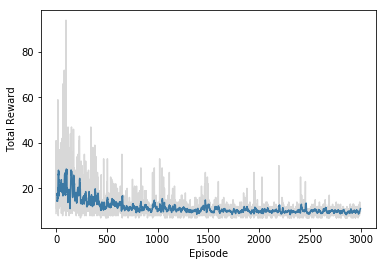

In [60]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.